In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import math
# import scipy
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy
# plot joint distribution of x in 2D with joint and marginal histograms

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.stats import gamma
from sklearn import metrics
# from sktree.datasets import make_trunk_classification, make_trunk_mixture_classification

def _moving_avg_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    cov_matrix = rho ** np.abs(i - j)

    # Apply the banding condition
    cov_matrix[abs(i - j) > 1] = 0
    return cov_matrix

In [3]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [4]:
def generate_mean_shift(mu0, mu1, sig0, sig1, n=10000, prior=[0.5, 0.5], mix=None):

    p = sig0.shape[0]
    p_class0, p_class1 = prior
    pdf_class0 = multivariate_normal(mean=mu0, cov=sig0, allow_singular=True)
    pdf_class1 = multivariate_normal(mean=mu1, cov=sig1, allow_singular=True)

    x_0 = pdf_class0.rvs(size=n).reshape((n, p))
    x_1 = pdf_class1.rvs(size=n).reshape((n, p))
    x = np.vstack((x_0, x_1))
    y = [0] * n + [1] * n

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1 = np.nan_to_num(pdf_class1.pdf(x))

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1

    pos_class0 = np.array(
        [
            p_x_given_class0[i] * p_class0 / p_x[i] if p_x[i] != 0 else 0
            for i in range(p_x.shape[0])
        ]
    ).reshape(-1, 1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0
    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))

    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0, p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    MI = entropy_y - stats_conen
    # calculate conditional mutual information
    # I(X; Y | Z) = H(X | Z) - H(X | Y, Z)

    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )
    s98 = np.max(tpr[fpr <= 0.02])

    AUC = roc_auc_score(y, posterior[:, 1])

    accuracy = np.mean(np.array(y) == np.argmax(posterior, axis=1))

    # create a dataframe with the data
    if p == 2:
        df = pd.DataFrame(x, columns=["view1", "view2"])
    else:
        df = pd.DataFrame(x)
    df["y"] = y
    # if p == 1:
    #     x_range = np.linspace(np.min(x), np.max(x), n)
    #     pdf0 = pdf_class0.pdf(x_range)
    #     pdf1 = pdf_class1.pdf(x_range)
    # else:
    #     x_range = np.linspace(np.min(x[:,0]), np.max(x[:,0]), n)
    #     y_range = np.linspace(np.min(x[:,1]), np.max(x[:,1]), n)
    #     xx, yy = np.meshgrid(x_range, y_range)
    #     xy_range = np.vstack((xx.flatten(), yy.flatten())).T
    #     pdf0 = pdf_class0.pdf(xy_range).reshape(n, n)
    #     pdf1 = pdf_class1.pdf(xy_range).reshape(n, n)

    results = {
        "df": df,
        # "val_range": x_range if p==1 else xy_range,
        # "pdf0": pdf0,
        # "pdf1": pdf1,
        "posterior": posterior,
        "MI": MI,
        "ACC": accuracy,
        "s98": s98,
        "AUC": AUC,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    }
    return results

In [5]:
def generate_multi_modal(
    mu0, mu1, sig0, sig1, p0=[0.75, 0.25], p1=[0.75, 0.25], n=100000, prior=[0.5, 0.5]
):
    # create an indicator for multi-equal simulation
    if np.array_equal(mu0, mu1) and np.array_equal(sig0, sig1 )and np.array_equal(p0, p1):
        multi_equal = True
    else:
        multi_equal = False

    p = sig0[0].shape[0]
    p_class0, p_class1 = prior
    # print(mu0,mu1)
    pdf_class0_1 = multivariate_normal(mean=mu0[0], cov=sig0[0], allow_singular=True)
    pdf_class0_2 = multivariate_normal(mean=mu0[1], cov=sig0[1], allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean=mu1[0], cov=sig1[0], allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean=mu1[1], cov=sig1[1], allow_singular=True)

    # print(pdf_class0_1.rvs(size = int(n*p0[0])).shape)
    x_0_1 = pdf_class0_1.rvs(size=int(n * p0[0])).reshape((int(n * p0[0]), p))
    x_0_2 = pdf_class0_2.rvs(size=int(n * p0[1])).reshape((int(n * p0[1]), p))
    x_1_1 = pdf_class1_1.rvs(size=int(n * p1[0])).reshape((int(n * p1[0]), p))
    x_1_2 = pdf_class1_2.rvs(size=int(n * p1[1])).reshape((int(n * p1[1]), p))

    # print(x_1_1)
    x_0 = np.vstack([x_0_1, x_0_2])
    x_1 = np.vstack([x_1_1, x_1_2])
    x = np.vstack((x_0_1, x_0_2, x_1_1, x_1_2))
    y = [0] * x_0.shape[0] + [1] * x_1.shape[0]
    # create a dataframe with the data
    if p == 2:
        df = pd.DataFrame(x, columns=["view1", "view2"])
    else:
        df = pd.DataFrame(x)
    df["y"] = y

    p_x_given_class0_1 = np.nan_to_num(pdf_class0_1.pdf(x))
    p_x_given_class0_2 = np.nan_to_num(pdf_class0_2.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(x))

    p_x_given_class0 = p0[0] * p_x_given_class0_1 + p0[1] * p_x_given_class0_2
    p_x_given_class1 = p1[0] * p_x_given_class1_1 + p1[1] * p_x_given_class1_2

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1
    # pos_class0 = p_x_given_class0*p_class0/p_x

    pos_class0 = np.array(
        [
            p_x_given_class0[i] * p_class0 / p_x[i] if p_x[i] != 0 else 0
            for i in range(p_x.shape[0])
        ]
    ).reshape(-1, 1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0
    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))

    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0, p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen

    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )

    if multi_equal or MI == 0.0:
        # replace the posterior with random numbers ~ U(0,1) to calculate the ROC curve
        posterior_ = np.random.uniform(0, 1, size=(df.shape[0], 2))
        fpr, tpr, thresholds = metrics.roc_curve(
            y, posterior_[:, 1], pos_label=1, drop_intermediate=False
        )

    s98 = np.max(tpr[fpr <= 0.02])

    AUC = roc_auc_score(y, posterior[:, 1])

    accuracy = np.mean(np.array(y) == np.argmax(posterior, axis=1))

    # if p==1:
    #     x_range = np.linspace(x.min(), x.max(), n)
    #     p_x_given_class0_1 = np.nan_to_num(pdf_class0_1.pdf(x_range))
    #     p_x_given_class0_2 = np.nan_to_num(pdf_class0_2.pdf(x_range))
    #     p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(x_range))
    #     p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(x_range))

    # else:
    #     x_range = np.linspace(x[:,0].min(), x[:,0].max(), n)
    #     y_range = np.linspace(x[:,1].min(), x[:,1].max(), n)
    #     xx, yy = np.meshgrid(x_range, y_range)
    #     xy_range = np.vstack((xx.flatten(), yy.flatten())).T
    #     p_x_given_class0_1 = np.nan_to_num(pdf_class0_1.pdf(xy_range))
    #     p_x_given_class0_2 = np.nan_to_num(pdf_class0_2.pdf(xy_range))
    #     p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(xy_range))
    #     p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(xy_range))

    # pdf0 = p0[0] * p_x_given_class0_1 + p0[1] * p_x_given_class0_2
    # pdf1 = p1[0] * p_x_given_class1_1 + p1[1] * p_x_given_class1_2

    results = {
        "df": df,
        # "val_range": x_range if p==1 else xy_range,
        # "pdf0": pdf0,
        # "pdf1": pdf1,
        "posterior": posterior,
        "ACC": accuracy,
        "MI": MI,
        "s98": s98,
        "AUC": AUC,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    }

    return results

In [6]:
n = 100000
p = 2
mu = 1
rho = 0.5
mu0 = np.zeros(p)
mu1 = np.array([1, 0])*mu
sig = np.identity(1)
sig0 = _moving_avg_cov(p, 0)
sig1 = _moving_avg_cov(p, rho)
# val_range = np.linspace(-5, 5, n)
bins = 50

# generate data
results = generate_mean_shift(mu0, mu1, sig0, sig1, n=n)
df = results["df"]
df.columns = ["view1", "view2", "y"]
# generate results for view 1
results_v1 = generate_mean_shift(mu0[0],mu1[0],sig, sig, n=n)
df_v1 = results_v1['df']
# generate results for view 2
results_v2 = generate_mean_shift(mu0[1],mu1[1],sig, sig, n=n)
df_v2 = results_v2['df']

df_roc = pd.DataFrame({"fpr": results['fpr'], "tpr": results['tpr'], "thresholds": results['thresholds']})
df_roc_v1 = pd.DataFrame({"fpr": results_v1['fpr'], "tpr": results_v1['tpr'], "thresholds": results_v1['thresholds']})
df_roc_v2 = pd.DataFrame({"fpr": results_v2['fpr'], "tpr": results_v2['tpr'], "thresholds": results_v2['thresholds']})
# marge the df_roc, df_roc_v1, df_roc_v2
df_roc_all = pd.concat([df_roc, df_roc_v1, df_roc_v2], axis=0)
# add a column to the df_roc_all denoting the view
df_roc_all['view'] = ['joint']*len(df_roc) + ['view1']*len(df_roc_v1) + ['view2']*len(df_roc_v2)

CMI_v1= results['MI'] - (results_v2['MI'])
CMI_v2= results['MI'] - (results_v1['MI'])

joint_stats = {'MI':results['MI'], 'CMI':"None", 's98':results['s98'], 'AUC':results['AUC'], "ACC":results["ACC"]}
view1_stats = {'MI':results_v1['MI'], "CMI":CMI_v1, 's98':results_v1['s98'], 'AUC':results_v1['AUC'], "ACC":results_v1["ACC"]}
view2_stats = {'MI':results_v2['MI'], "CMI":CMI_v2, 's98':results_v2['s98'], 'AUC':results_v2['AUC'], "ACC":results_v2["ACC"]}

# convert the results to a dataframe
df_stats = pd.DataFrame([joint_stats, view1_stats, view2_stats])
df_stats.index = ['joint', 'view1', 'view2']
display(df_stats)

# save the data as an array
mean_shift_data = [df, df_v1, df_v2, df_roc, df_roc_v1, df_roc_v2, df_stats]

# mean_shift_plot_range = [results['val_range'], results_v1['val_range'], results_v2['val_range']]
# mean_shift_plot_pdf0 = [results['pdf0'], results_v1['pdf0'], results_v2['pdf0']]
# mean_shift_plot_pdf1 = [results['pdf1'], results_v1['pdf1'], results_v2['pdf1']]

,MI,CMI,s98,AUC,ACC
joint,0.142717,None,0.17594,0.782919,0.70146
view1,0.111171,0.142717,0.14362,0.760728,0.69170
view2,0.000000,0.031545,0.00000,0.500000,0.50000


In [7]:
# n = 10000
rho = 0.5
rho_diag = 1
mu_0 = np.array([[0,0],[5,1]])
mu_1 = np.array([[0,0],[5,1]])
sig0 = _moving_avg_cov(2, rho)
sig1 = _moving_avg_cov(2, rho)
p0 = [0.75,0.25]
p1 = [0.75,0.25]
sig_0 = [sig0 ,sig0]
sig_1 = [sig1 ,sig1]

multi_equal_results_joint = generate_multi_modal(mu_0,mu_1,sig_0,sig_1,p0,p1, n=n)
multi_equal_results_v1 = generate_multi_modal(mu_0[:,0],mu_1[:,0],[np.identity(1),np.identity(1) ],[rho_diag*np.identity(1),rho_diag*np.identity(1)],p0,p1, n=n)
multi_equal_results_v2 = generate_multi_modal(mu_0[:,1],mu_1[:,1],[np.identity(1),np.identity(1) ],[rho_diag*np.identity(1),rho_diag*np.identity(1) ],p0,p1, n=n)

# create a dataframe with the results
multi_equal_df = multi_equal_results_joint['df']
multi_equal_df_v1 = multi_equal_results_v1['df']
multi_equal_df_v2 = multi_equal_results_v2['df']

multi_equal_df_roc = pd.DataFrame({"fpr": multi_equal_results_joint['fpr'], "tpr": multi_equal_results_joint['tpr'], "thresholds": multi_equal_results_joint['thresholds']})
multi_equal_df_roc_v1 = pd.DataFrame({"fpr": multi_equal_results_v1['fpr'], "tpr": multi_equal_results_v1['tpr'], "thresholds": multi_equal_results_v1['thresholds']})
multi_equal_df_roc_v2 = pd.DataFrame({"fpr": multi_equal_results_v2['fpr'], "tpr": multi_equal_results_v2['tpr'], "thresholds": multi_equal_results_v2['thresholds']})

CMI_v1= multi_equal_results_joint['MI'] - (multi_equal_results_v2['MI'])
CMI_v2= multi_equal_results_joint['MI'] - (multi_equal_results_v1['MI'])

multi_equal_joint_stats = {'MI':multi_equal_results_joint['MI'], 'CMI':"None", 's98':multi_equal_results_joint['s98'], 'AUC':multi_equal_results_joint['AUC'], "ACC":multi_equal_results_joint["ACC"]}
multi_equal_view1_stats = {'MI':multi_equal_results_v1['MI'], "CMI":CMI_v1, 's98':multi_equal_results_v1['s98'], 'AUC':multi_equal_results_v1['AUC'], "ACC":multi_equal_results_v1["ACC"]}
multi_equal_view2_stats = {'MI':multi_equal_results_v2['MI'], "CMI":CMI_v2, 's98':multi_equal_results_v2['s98'], 'AUC':multi_equal_results_v2['AUC'],  "ACC":multi_equal_results_v2["ACC"]}

# convert the results to a dataframe
multi_equal_df_stats = pd.DataFrame([multi_equal_joint_stats, multi_equal_view1_stats, multi_equal_view2_stats])
multi_equal_df_stats.index = ['joint', 'view1', 'view2']
display(multi_equal_df_stats.round(2))

# save the data as an array
multi_equal_data = [multi_equal_df, multi_equal_df_v1, multi_equal_df_v2, multi_equal_df_roc, multi_equal_df_roc_v1, multi_equal_df_roc_v2, multi_equal_df_stats]

# multi_equal_plot_range = [multi_equal_results_joint['val_range'], multi_equal_results_v1['val_range'], multi_equal_results_v2['val_range']]
# multi_equal_plot_pdf0 = [multi_equal_results_joint['pdf0'], multi_equal_results_v1['pdf0'], multi_equal_results_v2['pdf0']]
# multi_equal_plot_pdf1 = [multi_equal_results_joint['pdf1'], multi_equal_results_v1['pdf1'], multi_equal_results_v2['pdf1']]

,MI,CMI,s98,AUC,ACC
joint,0.0,None,0.02,0.5,0.5
view1,0.0,0.0,0.02,0.5,0.5
view2,0.0,0.0,0.02,0.5,0.5


In [8]:
# n = 10000
rho = 0.2
rho_diag = 1
mu_0 = np.array([[0, 0], [0, 0]])
mu_1 = np.array([[0, 0], [5, 1]])
sig0 = _moving_avg_cov(2, 0)
sig1 = _moving_avg_cov(2, rho)
p0 = [0.75, 0.25]
p1 = [0.75, 0.25]
sig_0 = [sig0, sig0]
sig_1 = [sig1, sig1]

multi_mod_results_joint = generate_multi_modal(mu_0, mu_1, sig_0, sig_1, p0, p1, n=n)
multi_mod_results_v1 = generate_multi_modal(
    mu_0[:, 0],
    mu_1[:, 0],
    [np.identity(1), np.identity(1)],
    [rho_diag * np.identity(1), rho_diag * np.identity(1)],
    p0,
    p1,
    n=n*2,
)
multi_mod_results_v2 = generate_multi_modal(
    mu_0[:, 1],
    mu_1[:, 1],
    [np.identity(1), np.identity(1)],
    [rho_diag * np.identity(1), rho_diag * np.identity(1)],
    p0,
    p1,
    n=n*2,
)

# create a dataframe with the results
multi_mod_df = multi_mod_results_joint["df"]
multi_mod_df_v1 = multi_mod_results_v1["df"]
multi_mod_df_v2 = multi_mod_results_v2["df"]

multi_mod_df_roc = pd.DataFrame(
    {
        "fpr": multi_mod_results_joint["fpr"],
        "tpr": multi_mod_results_joint["tpr"],
        "thresholds": multi_mod_results_joint["thresholds"],
    }
)
multi_mod_df_roc_v1 = pd.DataFrame(
    {
        "fpr": multi_mod_results_v1["fpr"],
        "tpr": multi_mod_results_v1["tpr"],
        "thresholds": multi_mod_results_v1["thresholds"],
    }
)
multi_mod_df_roc_v2 = pd.DataFrame(
    {
        "fpr": multi_mod_results_v2["fpr"],
        "tpr": multi_mod_results_v2["tpr"],
        "thresholds": multi_mod_results_v2["thresholds"],
    }
)

CMI_v1 = multi_mod_results_joint["MI"] - (multi_mod_results_v2["MI"])
CMI_v2 = multi_mod_results_joint["MI"] - (multi_mod_results_v1["MI"])

multi_mod_joint_stats = {
    "MI": multi_mod_results_joint["MI"],
    "CMI": "None",
    "s98": multi_mod_results_joint["s98"],
    "AUC": multi_mod_results_joint["AUC"],
    "ACC": multi_mod_results_joint["ACC"],
}
multi_mod_view1_stats = {
    "MI": multi_mod_results_v1["MI"],
    "CMI": CMI_v1,
    "s98": multi_mod_results_v1["s98"],
    "AUC": multi_mod_results_v1["AUC"],
    "ACC": multi_mod_results_v1["ACC"],
}
multi_mod_view2_stats = {
    "MI": multi_mod_results_v2["MI"],
    "CMI": CMI_v2,
    "s98": multi_mod_results_v2["s98"],
    "AUC": multi_mod_results_v2["AUC"],
    "ACC": multi_mod_results_v2["ACC"],
}

# convert the results to a dataframe
multi_mod_df_stats = pd.DataFrame(
    [multi_mod_joint_stats, multi_mod_view1_stats, multi_mod_view2_stats]
)
# label the rows as joint, view1, view2
multi_mod_df_stats.index = ["joint", "view1", "view2"]
display(multi_mod_df_stats)

# save the data as an array
multi_mod_data = [
    multi_mod_df,
    multi_mod_df_v1,
    multi_mod_df_v2,
    multi_mod_df_roc,
    multi_mod_df_roc_v1,
    multi_mod_df_roc_v2,
    multi_mod_df_stats,
]

# multi_mod_plot_range = [
#     multi_mod_results_joint["val_range"],
#     multi_mod_results_v1["val_range"],
#     multi_mod_results_v2["val_range"],
# ]
# multi_mod_plot_pdf0 = [
#     multi_mod_results_joint["pdf0"],
#     multi_mod_results_v1["pdf0"],
#     multi_mod_results_v2["pdf0"],
# ]
# multi_mod_plot_pdf1 = [
#     multi_mod_results_joint["pdf1"],
#     multi_mod_results_v1["pdf1"],
#     multi_mod_results_v2["pdf1"],
# ]


,MI,CMI,s98,AUC,ACC
joint,0.096611,None,0.27290,0.661468,0.627010
view1,0.092129,0.087863,0.26492,0.624276,0.623472
view2,0.008748,0.004483,0.05142,0.564896,0.548098


In [ ]:
# combine the data for plotting in a single array
# val_ranges = [mean_shift_plot_range, multi_equal_plot_range, multi_mod_plot_range]
# pdf0s = [mean_shift_plot_pdf0, multi_equal_plot_pdf0, multi_mod_plot_pdf0]
# pdf1s = [mean_shift_plot_pdf1, multi_equal_plot_pdf1, multi_mod_plot_pdf1]

In [9]:
1# combine the data
all_data = [mean_shift_data, multi_mod_data, multi_equal_data]
# print(all_data)

# add a clumn to indicate the label for Control and Case
for i in range(len(all_data)):
    all_data[i][0]['label'] = ['Control' if i == 0 else 'Case' for i in all_data[i][0]['y']]

stats_mean_shift, stats_multi_mod, stats_multi_equal = [
    mean_shift_data[-1],
    multi_mod_data[-1],
    multi_equal_data[-1],
]
# concatenate the data and transpose
all_stats = pd.concat([stats_mean_shift, stats_multi_mod, stats_multi_equal], axis=0)
# create a new column to denote the dataset
all_stats["Simulation"] = ["Linear"] * 3 + ["Non-linear"] * 3 + ["Independent"] * 3
# convert the index to a column with the name 'view'
all_stats.reset_index(inplace=True)
all_stats.rename(columns={"index": "View"}, inplace=True)
# melt the data to long format
all_stats_long = all_stats.melt(
    id_vars=["Simulation", "View"],
    value_vars=["MI", "s98", "AUC", "ACC"],
    var_name="Statistic",
    value_name="Value",
)
# remove the row where the statistic is CMI for the joint view
print(print(all_stats_long))
all_stats_long.drop(index = [9,10,11,12,13,14,15,16,17],axis = 0)

# group the data by the Simulation and view
all_stats_long = all_stats_long.pivot_table(
    index=["Simulation", "View"], columns="Statistic", values="Value"
)
# pivot the data by the Simulation and view
# all_stats_long.drop('CMI', axis=1, level=1, inplace=True)
# round the values to 2 decimal places for MI, CMI, s98, AUC, and Acc
d = np.round(all_stats_long, 2).T

# convert the levels to a row
# d.reset_index(inplace=True)

# display(all_stats.round(2))
display(d)

     Simulation   View Statistic     Value
0        Linear  joint        MI  0.142717
1        Linear  view1        MI  0.111171
2        Linear  view2        MI  0.000000
3    Non-linear  joint        MI  0.096611
4    Non-linear  view1        MI  0.092129
5    Non-linear  view2        MI  0.008748
6   Independent  joint        MI  0.000000
7   Independent  view1        MI  0.000000
8   Independent  view2        MI  0.000000
9        Linear  joint       s98  0.175940
10       Linear  view1       s98  0.143620
11       Linear  view2       s98  0.000000
12   Non-linear  joint       s98  0.272900
13   Non-linear  view1       s98  0.264920
14   Non-linear  view2       s98  0.051420
15  Independent  joint       s98  0.021190
16  Independent  view1       s98  0.020220
17  Independent  view2       s98  0.019660
18       Linear  joint       AUC  0.782919
19       Linear  view1       AUC  0.760728
20       Linear  view2       AUC  0.500000
21   Non-linear  joint       AUC  0.661468
22   Non-li

Simulation Independent             Linear             Non-linear            
View             joint view1 view2  joint view1 view2      joint view1 view2
Statistic                                                                   
ACC               0.50  0.50  0.50   0.70  0.69   0.5       0.63  0.62  0.55
AUC               0.50  0.50  0.50   0.78  0.76   0.5       0.66  0.62  0.56
MI                0.00  0.00  0.00   0.14  0.11   0.0       0.10  0.09  0.01
s98               0.02  0.02  0.02   0.18  0.14   0.0       0.27  0.26  0.05

In [ ]:
# #supress the warnings
# import warnings

# warnings.filterwarnings('ignore')

# sns.set_theme(color_codes=True, style="white", context="talk", font_scale=1)
# PALETTE = sns.color_palette("Set1")
# # swap the first and second colors
# PALETTE[0], PALETTE[1] = PALETTE[1], PALETTE[0]
# sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
# NCOLS = 3
# NROWS = 1
# SIMULATIONS = ['Linear', 'Non-linear', 'Independent']
# fontsize = 22
# skip = n // 6000
# density = True
# bins = 30

# plt.close('all')
# fig = plt.figure(figsize=(24, 8))
# gs = gridspec.GridSpec(NROWS, NCOLS, fig)
# sns.set_style("white", {"axes.edgecolor": "#dddddd"})
# for i in range(NCOLS):
#     df = all_data[i][0]
#     x, y = df["view1"], df["view2"]
#     # val_range_joint, val_range_v1, val_range_v2 = val_ranges[i]
#     # pdf0_joint, pdf0_v1, pdf0_v2 = pdf0s[i]
#     # pdf1_joint, pdf1_v1, pdf1_v2 = pdf1s[i]
#     # find the range of values for view 1 and view 2
#     x_min, x_max = df["view1"].min(), df["view1"].max()
#     y_min, y_max = df["view2"].min(), df["view2"].max()
#     g1 = sns.jointplot(
#         data=df[::skip],
#         x="view1",
#         y="view2",
#         hue="y",
#         alpha=0.2,
#         palette=PALETTE[:2],
#         legend=False,
#         markers=".",
#         linewidth=0,
#         s=10,
#         height=8,
#         xlim=(x_min, x_max),
#         ylim=(y_min, y_max),
#         # marginal_kws={'kde':True},
#     )
#     g1.set_axis_labels("View 1", "View 2")
#     # g1.plot(sns.scatterplot, sns.histplot, data=df[::skip], alpha=.2, edgecolor="None", linewidth=0, legend=False,)
#     g1.plot_joint(sns.kdeplot, data=df, fill=False, levels=10, alpha=.7, linewidths=2.0, palette=PALETTE)
#     g1.plot_joint(sns.scatterplot, data=df[::skip], alpha=0.1, edgecolor="None", linewidth=0, legend=False)
#     g1.ax_marg_x.set_xlim(x_min, x_max)
#     g1.ax_marg_y.set_ylim(y_min, y_max)
#     g1.plot_marginals(sns.histplot, data=df, kde=True, alpha=0.5, bins=bins)
#     # g1.ax_marg_x.hist(x[:len(x)//2], bins=bins, color=PALETTE[0], alpha=0.5, density=density,)
#     # g1.ax_marg_x.hist(x[len(x)//2:], bins=bins, color=PALETTE[1], alpha=0.5, density=density)
#     # g1.ax_marg_y.hist(y[:len(x)//2], bins=bins, color=PALETTE[0], alpha=0.5, density=density, orientation="horizontal")
#     # g1.ax_marg_y.hist(y[len(x)//2:], bins=bins, color=PALETTE[1], alpha=0.5, density=density, orientation="horizontal")
#     # g1.ax_marg_x.plot(val_range_v1, pdf0_v1, label="Control")
#     # g1.ax_marg_x.plot(val_range_v1, pdf1_v1, label="Case")
#     # g1.ax_marg_y.plot(pdf0_v2, val_range_v2, color=PALETTE[2], label="Control")
#     # g1.ax_marg_y.plot(pdf1_v2, val_range_v2, color=PALETTE[3], label="Case")
#     # add title
#     g1.figure.suptitle(SIMULATIONS[i], fontsize=fontsize)
#     mg1 = SeabornFig2Grid(g1, fig, gs[i])

# gs.tight_layout(fig)
# # gs.update(top=1.0)
# # plt.suptitle("Joint distribution of views 1 and 2", fontsize=fontsize)

# plt.show()

## TO DO 03/18:

Separate truth into a sub table within the figures and then a separate supplemental table with all the values -- done

Histogram and densities on the top row and ROC on the bottom -- done

Make figues all squre --done

Add ABCDEF for subplots


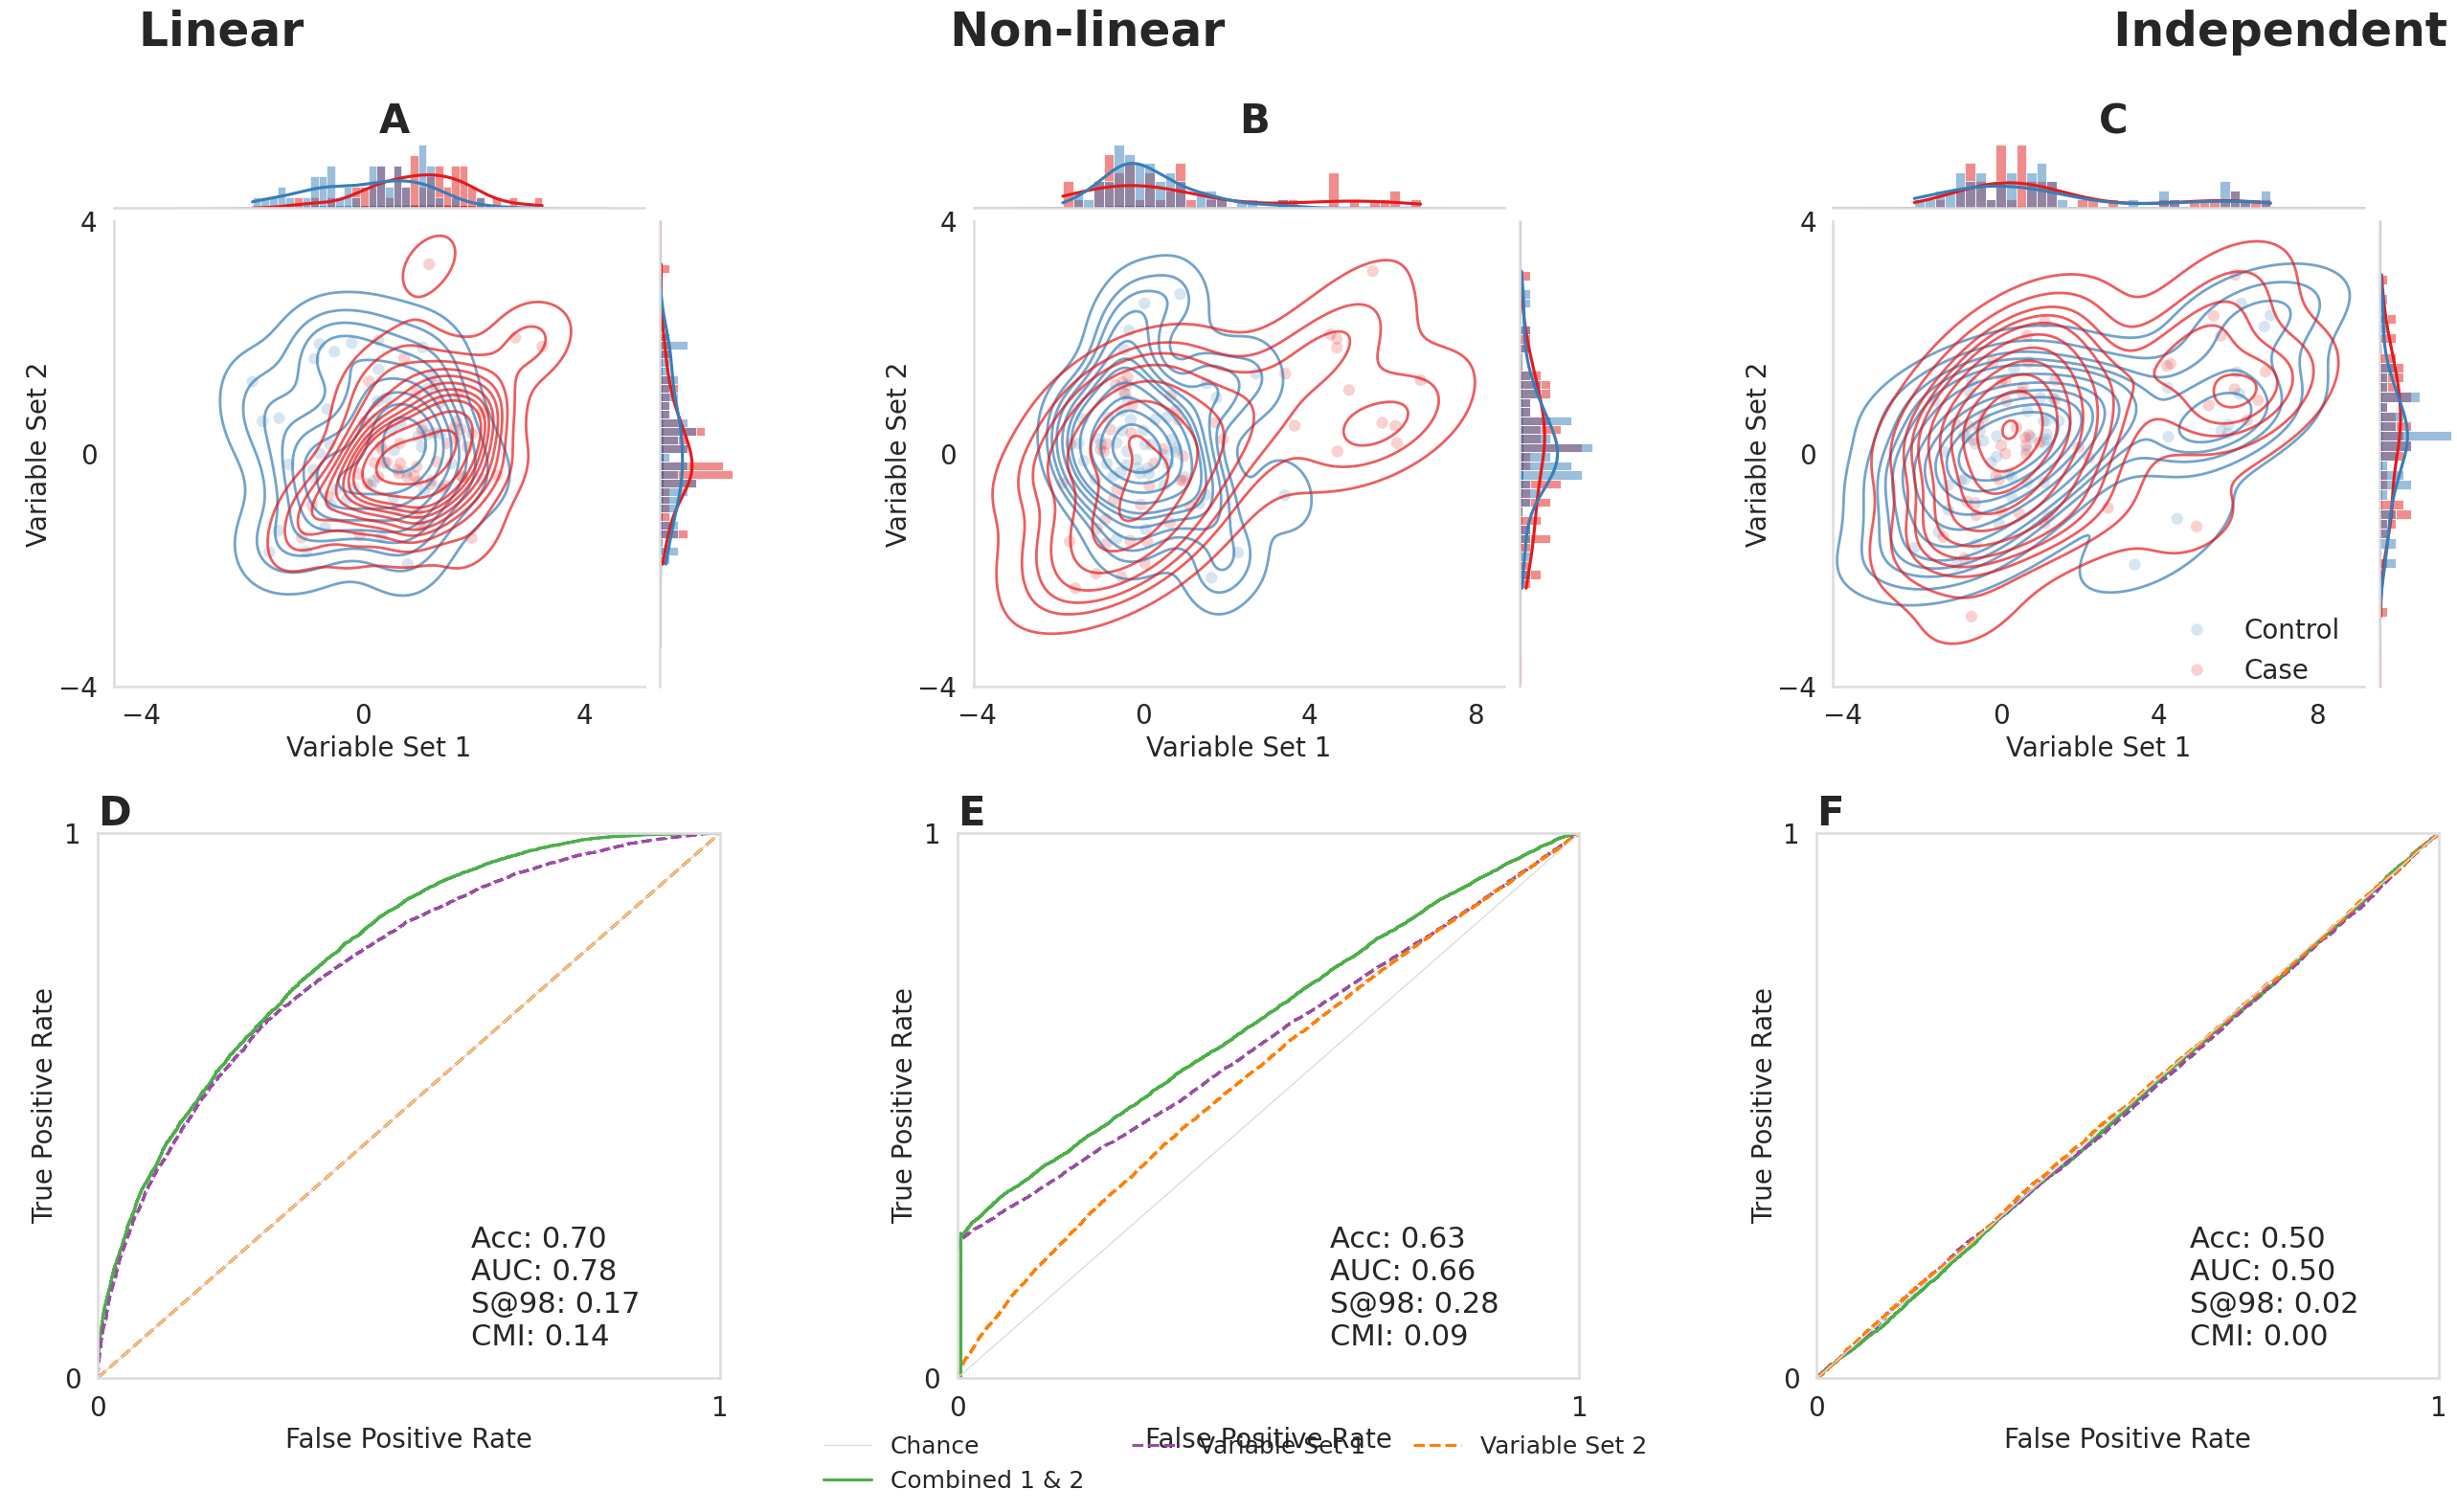

In [ ]:
#supress the warnings
from unittest import skip
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.pyplot import title
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
# import string
warnings.filterwarnings('ignore')

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")
# swap the first and second colors
PALETTE[0], PALETTE[1] = PALETTE[1], PALETTE[0]
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
SIMULATIONS = ['Linear', 'Non-linear', 'Independent']
NCOLS = 3
NROWS = 2
density = False
fontsize = axislabelfontsize =titlefontsize= 20
fig = plt.figure(figsize=(26, 15))
gs = gridspec.GridSpec(NROWS, NCOLS, fig)
sns.set_style("white", {"axes.edgecolor": "#dddddd"})

ROW = 0
fig_labels = ['A', 'B', 'C']
spacings = [18, 14, 12]
skip = n//50
levels = 12
bins = 35

for i in range(NCOLS):
    df = all_data[i][0]
    df_ = df[::skip]
    x_min, x_max = df["view1"].min(), df["view1"].max()
    y_min, y_max = df["view2"].min(), df["view2"].max()
    x, y = df["view1"], df["view2"]
    g1 = sns.jointplot(
        data=df_,
        x="view1",
        y="view2",
        # x=x,
        # y=y,
        hue=df["label"],
        alpha=0,
        palette=PALETTE,
        legend=False,
        markers=".",
        linewidth=0,
        s=0,
        # height=15,
        xlim=(x_min, x_max),
        ylim=(-4, 4),

    )

    g1.set_axis_labels("Variable Set 1", "Variable Set 2", fontsize=axislabelfontsize)
    if i == 0:
      g1.ax_joint.set_xticks([-4, 0,4])
      g1.ax_joint.set_yticks([-4, 0, 4])
    else:
      g1.ax_joint.set_xticks([-4, 0,4,8])
      g1.ax_joint.set_yticks([-4, 0, 4])
    g1.ax_joint.tick_params(axis='both', which='major', labelsize=axislabelfontsize)
    g1.figure.subplots_adjust(top=1) # Reduce plot to make room
    # sns.scatterplot(x="view1",y="view2",data = df.iloc[[10*i for i in range(int(df.shape[0]/10))],:],palette=PALETTE[:2],hue='label',alpha = 0.5)
    # sns.scatterplot(x="view1",y="view2",data =all_data[i][0][::100],palette=PALETTE[:2],hue='label',alpha = 0.5)


    # g1.plot(sns.scatterplot, sns.histplot, alpha=.2, edgecolor="None", linewidth=0, legend=False,palette=PALETTE[:2])
    g1.plot_joint(sns.kdeplot, data=df, fill=False, alpha=0.7, levels=levels, linewidths=2.0, palette=PALETTE)
    # g1.plot_joint(sns.scatterplot, alpha=0.1, edgecolor="None", linewidth=0, legend=False,)
    sns.scatterplot(data=df_, x='view1', y='view2', hue=df_["label"], palette=PALETTE[:2], alpha = 0.2)

    # g1.plot_marginals(sns.histplot,bins=50,alpha = 0.5,kde = True)
    # remove the legend
    g1.ax_joint.legend_.remove()
    g1.ax_marg_x.title.set_text(fig_labels[i],)
    g1.ax_marg_x.title.set_fontweight('bold')
    g1.ax_marg_x.title.set_horizontalalignment('left')
    g1.ax_marg_x.title.set_fontsize(titlefontsize+10)
    g1.plot_marginals(sns.histplot, data=df, kde=True, bins=bins)
    # sns.histplot(data=df_, x='view1', bins=bins, hue=df_['y'], alpha=0.5, density=density, ax=g1.ax_marg_x)
    # g1.plot_marginals(sns.histplot, data=df, kde=True, bins=bins
    # sns.histplot(data=df_, x='view2', bins=bins, color=PALETTE[1], alpha=0.5, density=density, ax=g1.ax_marg_y)

    # g1.ax_marg_x.hist(x[:len(x)//2], bins=bins, color=PALETTE[0], alpha=0.5, density=density)
    # g1.ax_marg_x.hist(x[len(x)//2:], bins=bins, color=PALETTE[1], alpha=0.5, density=density)
    # g1.ax_marg_y.hist(y[:len(x)//2], bins=bins, color=PALETTE[0], alpha=0.5, density=density, orientation="horizontal")
    # g1.ax_marg_y.hist(y[len(x)//2:], bins=bins, color=PALETTE[1], alpha=0.5, density=density, orientation="horizontal")
    # g1.ax_marg_x.plot(results_v1['val_range'], results_v1['pdf0'], color=PALETTE[0])
    # g1.ax_marg_x.plot(results_v1['val_range'], results_v1['pdf1'], color=PALETTE[1])
    # g1.ax_marg_y.plot(results_v2['pdf0'],results_v2['val_range'], color=PALETTE[0])
    # g1.ax_marg_y.plot(results_v2['pdf1'],results_v2['val_range'],color=PALETTE[1])
    # g1.ax_marg_y.legend_.
    # change the legend
    if i ==2:
      g1.ax_joint.legend(fontsize=fontsize, frameon=False, loc="upper right",bbox_to_anchor=(1,0.2))
      # change the legend title and labels
      g1.ax_joint.get_legend().set_title("")

      # g1.ax_joint.get_legend().set_labels(["Control", "Case"])

    mg1 = SeabornFig2Grid(g1, fig, gs[ROW, i])

ROW += 1
# ax = plt.subplots(nrows=1, ncols=3, figsize=(26,8), gridspec_kw={'width_ratios': [.8, .8, .8]})
fig_labels = ['D', 'E', 'F']
for i in range(NCOLS):
    df_roc, df_roc_v1, df_roc_v2 = all_data[i][3:6]
    ax = fig.add_subplot(gs[ROW, i]) # aspect=1.0
    # ax.set_aspect('equal')
    # ax.set_aspect(0.95)
    # sns.lineplot(data=df_roc_all, x="fpr", y="tpr", hue="view", ax=ax)
    # ax.set_title(SIMULATIONS[i], fontsize=titlefontsize)
    ax.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[2], label="Combined 1 & 2", linestyle="-")
    ax.plot(df_roc_v1["fpr"], df_roc_v1["tpr"], color=PALETTE[3], label="Variable Set 1", linestyle="--")
    ax.plot(
        df_roc_v2["fpr"],
        df_roc_v2["tpr"],
        color=PALETTE[4],
        linestyle="--",
        label="Variable Set 2",
    )
    if i == 1:
        # get the s98 values
        s98 = all_data[i][6].loc['joint', 's98']
        ax.vlines(x=0.005, ymin=0,ymax=s98-0.01, color=PALETTE[2], linestyle='-')
    ax.set_xlabel("False Positive Rate", fontsize=axislabelfontsize)
    ax.set_ylabel("True Positive Rate", fontsize=axislabelfontsize)
    ax.set_title(fig_labels[i], loc="left", weight='bold', fontsize=fontsize+10)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_ylim(top=1)
    ax.set_xlim(right=1)
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.tick_params(axis='both', which='major', labelsize=axislabelfontsize)
    ax.set_axisbelow(True)
    ax.spines['left'].set_color('#dddddd')
    ax.spines['right'].set_color('#dddddd')
    ax.spines['top'].set_color('#dddddd')
    ax.spines['bottom'].set_color('#dddddd')
    ax.plot([0, 1], [0, 1], color='#dddddd', lw=1, linestyle="-", label="Chance")
    if i ==1:
      ax.legend(fontsize=fontsize, frameon=False)
      handles, labels = ax.get_legend_handles_labels()
      # sort both labels and handles by labels
      labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
      ax.legend(handles, labels, fontsize=fontsize-2, frameon=False,loc="lower left",ncol = 3,bbox_to_anchor=(-0.25,-0.25))

    # plt.subplots_adjust(wspace=1)

    # annotate the stats on the plot
    stats = all_data[i][6]
    # print(stats)
    MI = stats.loc['joint', "MI"]
    CMI = stats.loc['view1', "CMI"]
    s98 = stats.loc['joint', "s98"]
    AUC = stats.loc['joint', "AUC"]
    Acc = stats.loc['joint', "ACC"]
    x_pos = 0.6
    y_pos = 0.1
    k = 0.06
    for j, txt in enumerate([f"CMI: {CMI:.2f}", f"S@98: {s98:.2f}", f"AUC: {AUC:.2f}", f"Acc: {Acc:.2f}"]):
        ax.text(x_pos, y_pos+k*j, txt, transform=ax.transAxes, fontsize=fontsize+2, verticalalignment='top', horizontalalignment='left')


gs.tight_layout(fig)
plt.suptitle(str(' '*8 + "Linear" + ' '*40 + "Non-linear" +' '*55 + "Independent"), fontsize=fontsize+15, y=1.05, fontweight='bold', horizontalalignment='center')
# save as .svg
plt.savefig("figure-s4.svg", format='svg', bbox_inches='tight')
plt.show()

# To Do 03/21:
1. Add a "chance", [-4,0,4,8] at x axis for B and C

2. label title more vertically separated from histogram (might not be necessary after moving histograms)

3. move histograms on right-y-axis to LHS and top-x-axis to bottom.



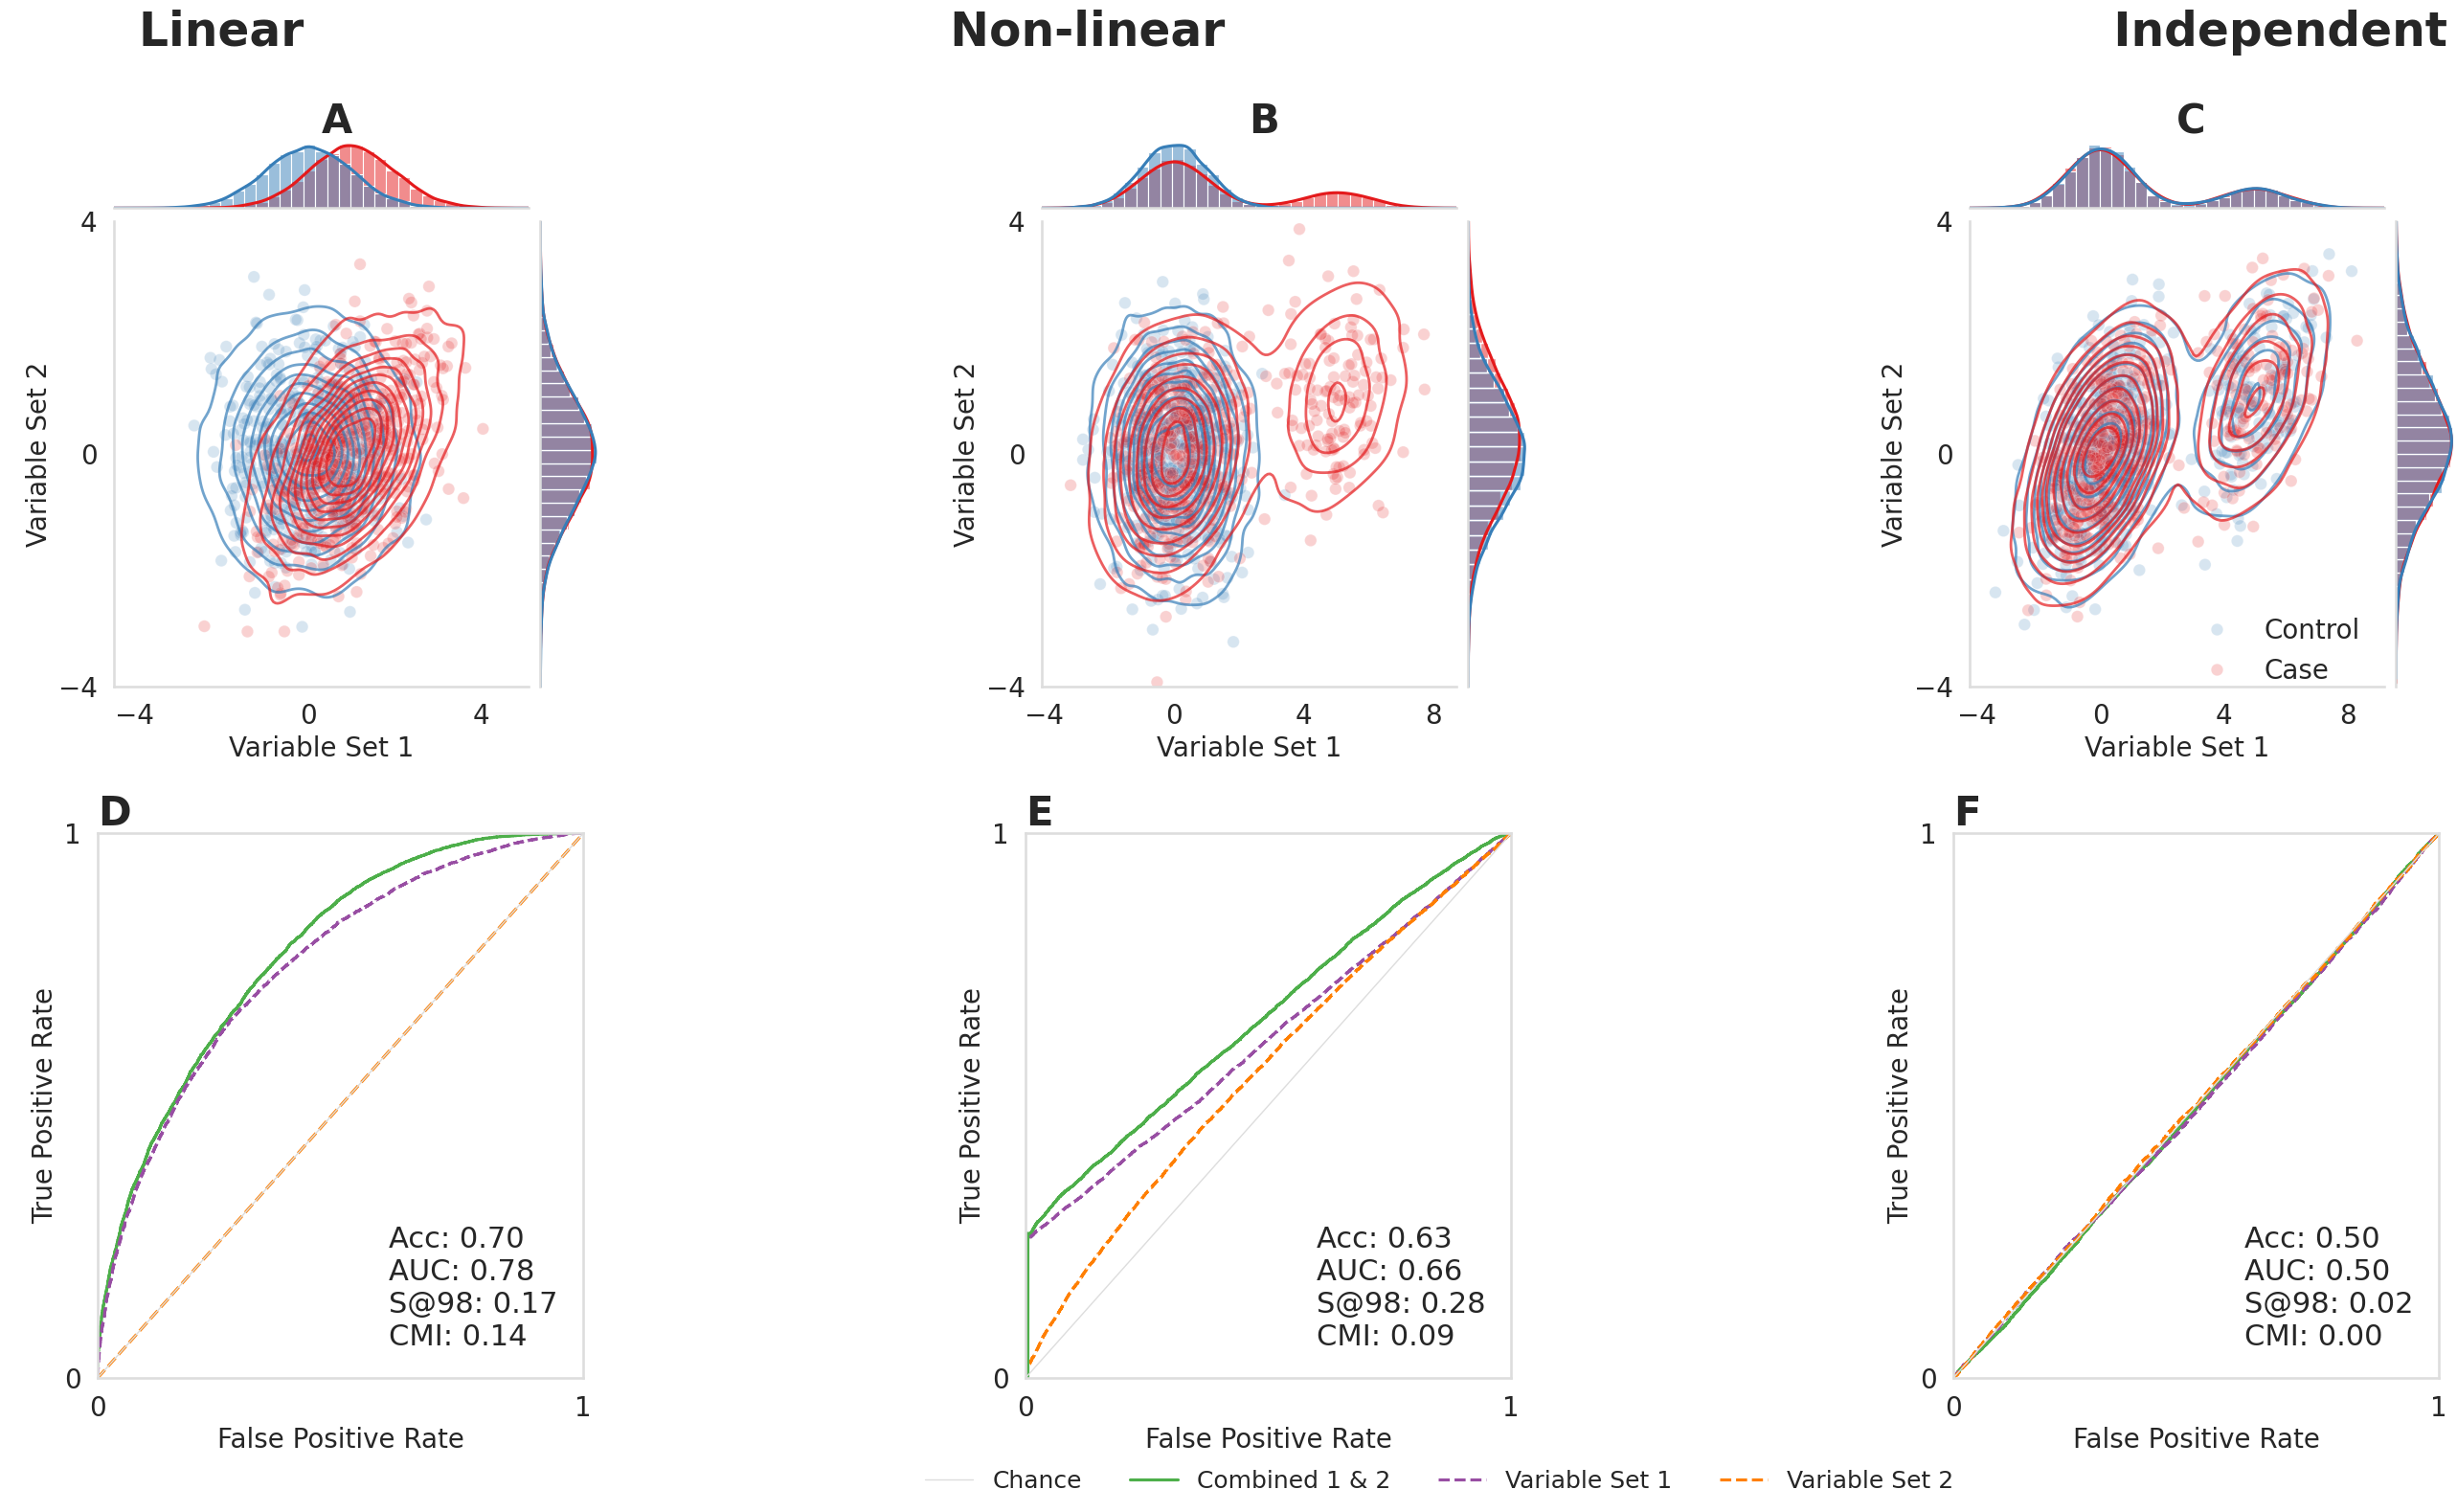

In [ ]:
#supress the warnings
from unittest import skip
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.pyplot import title
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
# import string
warnings.filterwarnings('ignore')

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")
# swap the first and second colors
PALETTE[0], PALETTE[1] = PALETTE[1], PALETTE[0]
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
SIMULATIONS = ['Linear', 'Non-linear', 'Independent']
NCOLS = 3
NROWS = 2
density = False
fontsize = axislabelfontsize =titlefontsize= 20
fig = plt.figure(figsize=(26, 15))
gs = gridspec.GridSpec(NROWS, NCOLS, fig)
sns.set_style("white", {"axes.edgecolor": "#dddddd"})

ROW = 0
fig_labels = ['A', 'B', 'C']
spacings = [18, 14, 12]
skip = n//500
levels = 12
bins = 35

for i in range(NCOLS):
    df = all_data[i][0]
    df_ = df[::skip]
    x_min, x_max = df["view1"].min(), df["view1"].max()
    y_min, y_max = df["view2"].min(), df["view2"].max()
    x, y = df["view1"], df["view2"]
    g1 = sns.jointplot(
        data=df,
        x="view1",
        y="view2",
        # x=x,
        # y=y,
        hue=df["label"],
        alpha=0,
        palette=PALETTE,
        legend=False,
        markers=".",
        linewidth=0,
        s=0,
        # height=15,
        xlim=(x_min, x_max),
        ylim=(-4, 4),

    )

    g1.set_axis_labels("Variable Set 1", "Variable Set 2", fontsize=axislabelfontsize)
    if i == 0:
      g1.ax_joint.set_xticks([-4, 0,4])
      g1.ax_joint.set_yticks([-4, 0, 4])
    else:
      g1.ax_joint.set_xticks([-4, 0,4,8])
      g1.ax_joint.set_yticks([-4, 0, 4])
    g1.ax_joint.tick_params(axis='both', which='major', labelsize=axislabelfontsize)
    g1.figure.subplots_adjust(top=1) # Reduce plot to make room
    # sns.scatterplot(x="view1",y="view2",data = df.iloc[[10*i for i in range(int(df.shape[0]/10))],:],palette=PALETTE[:2],hue='label',alpha = 0.5)
    # sns.scatterplot(x="view1",y="view2",data =all_data[i][0][::100],palette=PALETTE[:2],hue='label',alpha = 0.5)


    # g1.plot(sns.scatterplot, sns.histplot, alpha=.2, edgecolor="None", linewidth=0, legend=False,palette=PALETTE[:2])
    g1.plot_joint(sns.kdeplot, data=df, fill=False, alpha=0.7, levels=levels, linewidths=2.0, palette=PALETTE)
    # g1.plot_joint(sns.scatterplot, alpha=0.1, edgecolor="None", linewidth=0, legend=False,)
    sns.scatterplot(data=df_, x='view1', y='view2', hue=df_["label"], palette=PALETTE[:2], alpha = 0.2)

    # g1.plot_marginals(sns.histplot,bins=50,alpha = 0.5,kde = True)
    # remove the legend
    g1.ax_joint.legend_.remove()
    g1.ax_marg_x.title.set_text(fig_labels[i],)
    g1.ax_marg_x.title.set_fontweight('bold')
    g1.ax_marg_x.title.set_horizontalalignment('left')
    g1.ax_marg_x.title.set_fontsize(titlefontsize+10)
    g1.plot_marginals(sns.histplot, data=df, kde=True, bins=bins)
    # sns.histplot(data=df_, x='view1', bins=bins, hue=df_['y'], alpha=0.5, density=density, ax=g1.ax_marg_x)
    # g1.plot_marginals(sns.histplot, data=df, kde=True, bins=bins
    # sns.histplot(data=df_, x='view2', bins=bins, color=PALETTE[1], alpha=0.5, density=density, ax=g1.ax_marg_y)

    # g1.ax_marg_x.hist(x[:len(x)//2], bins=bins, color=PALETTE[0], alpha=0.5, density=density)
    # g1.ax_marg_x.hist(x[len(x)//2:], bins=bins, color=PALETTE[1], alpha=0.5, density=density)
    # g1.ax_marg_y.hist(y[:len(x)//2], bins=bins, color=PALETTE[0], alpha=0.5, density=density, orientation="horizontal")
    # g1.ax_marg_y.hist(y[len(x)//2:], bins=bins, color=PALETTE[1], alpha=0.5, density=density, orientation="horizontal")
    # g1.ax_marg_x.plot(results_v1['val_range'], results_v1['pdf0'], color=PALETTE[0])
    # g1.ax_marg_x.plot(results_v1['val_range'], results_v1['pdf1'], color=PALETTE[1])
    # g1.ax_marg_y.plot(results_v2['pdf0'],results_v2['val_range'], color=PALETTE[0])
    # g1.ax_marg_y.plot(results_v2['pdf1'],results_v2['val_range'],color=PALETTE[1])
    # g1.ax_marg_y.legend_.
    # change the legend
    if i ==2:
      g1.ax_joint.legend(fontsize=fontsize, frameon=False, loc="upper right",bbox_to_anchor=(1,0.2))
      # change the legend title and labels
      g1.ax_joint.get_legend().set_title("")

      # g1.ax_joint.get_legend().set_labels(["Control", "Case"])

    mg1 = SeabornFig2Grid(g1, fig, gs[ROW, i])

ROW += 1
# ax = plt.subplots(nrows=1, ncols=3, figsize=(26,8), gridspec_kw={'width_ratios': [.8, .8, .8]})
fig_labels = ['D', 'E', 'F']
for i in range(NCOLS):
    df_roc, df_roc_v1, df_roc_v2 = all_data[i][3:6]
    ax = fig.add_subplot(gs[ROW, i]) # aspect=1.0
    # ax.set_aspect('equal')
    # ax.set_aspect(0.95)
    # sns.lineplot(data=df_roc_all, x="fpr", y="tpr", hue="view", ax=ax)
    # ax.set_title(SIMULATIONS[i], fontsize=titlefontsize)
    ax.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[2], label="Combined 1 & 2", linestyle="-")
    ax.plot(df_roc_v1["fpr"], df_roc_v1["tpr"], color=PALETTE[3], label="Variable Set 1", linestyle="--")
    ax.plot(
        df_roc_v2["fpr"],
        df_roc_v2["tpr"],
        color=PALETTE[4],
        linestyle="--",
        label="Variable Set 2",
    )
    if i == 1:
        # get the s98 values
        s98 = all_data[i][6].loc['joint', 's98']
        ax.vlines(x=0.005, ymin=0,ymax=s98-0.01, color=PALETTE[2], linestyle='-')
    ax.set_xlabel("False Positive Rate", fontsize=axislabelfontsize)
    ax.set_ylabel("True Positive Rate", fontsize=axislabelfontsize)
    ax.set_title(fig_labels[i], loc="left", weight='bold', fontsize=fontsize+10)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_ylim(top=1)
    ax.set_xlim(right=1)
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.tick_params(axis='both', which='major', labelsize=axislabelfontsize)
    ax.set_axisbelow(True)
    ax.spines['left'].set_color('#dddddd')
    ax.spines['right'].set_color('#dddddd')
    ax.spines['top'].set_color('#dddddd')
    ax.spines['bottom'].set_color('#dddddd')
    ax.plot([0, 1], [0, 1], color='#dddddd', lw=1, linestyle="-", label="Chance")
    if i ==1:
      ax.legend(fontsize=fontsize, frameon=False)
      handles, labels = ax.get_legend_handles_labels()
      # sort both labels and handles by labels
      labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
      ax.legend(handles, labels, fontsize=fontsize-2, frameon=False,loc="lower left",ncol = 4,bbox_to_anchor=(-0.25,-0.25))

    # plt.subplots_adjust(wspace=1)

    # annotate the stats on the plot
    stats = all_data[i][6]
    # print(stats)
    MI = stats.loc['joint', "MI"]
    CMI = stats.loc['view1', "CMI"]
    s98 = stats.loc['joint', "s98"]
    AUC = stats.loc['joint', "AUC"]
    Acc = stats.loc['joint', "ACC"]
    x_pos = 0.6
    y_pos = 0.1
    k = 0.06
    for j, txt in enumerate([f"CMI: {CMI:.2f}", f"S@98: {s98:.2f}", f"AUC: {AUC:.2f}", f"Acc: {Acc:.2f}"]):
        ax.text(x_pos, y_pos+k*j, txt, transform=ax.transAxes, fontsize=fontsize+2, verticalalignment='top', horizontalalignment='left')


gs.tight_layout(fig)
plt.suptitle(str(' '*8 + "Linear" + ' '*40 + "Non-linear" +' '*55 + "Independent"), fontsize=fontsize+15, y=1.05, fontweight='bold', horizontalalignment='center')
# save as .svg
# plt.savefig("figure-s4.svg", format='svg', bbox_inches='tight')
plt.show()

TO Do:

1. Try a different way to do jointplot

2. Move AUC before the Acc

3.  Remove the legend

['Combined 1 & 2', 'Variable Set 1', 'Variable Set 2', 'Chance']
['Combined 1 & 2', 'Variable Set 1', 'Variable Set 2', 'Chance']
['Combined 1 & 2', 'Variable Set 1', 'Variable Set 2', 'Chance']


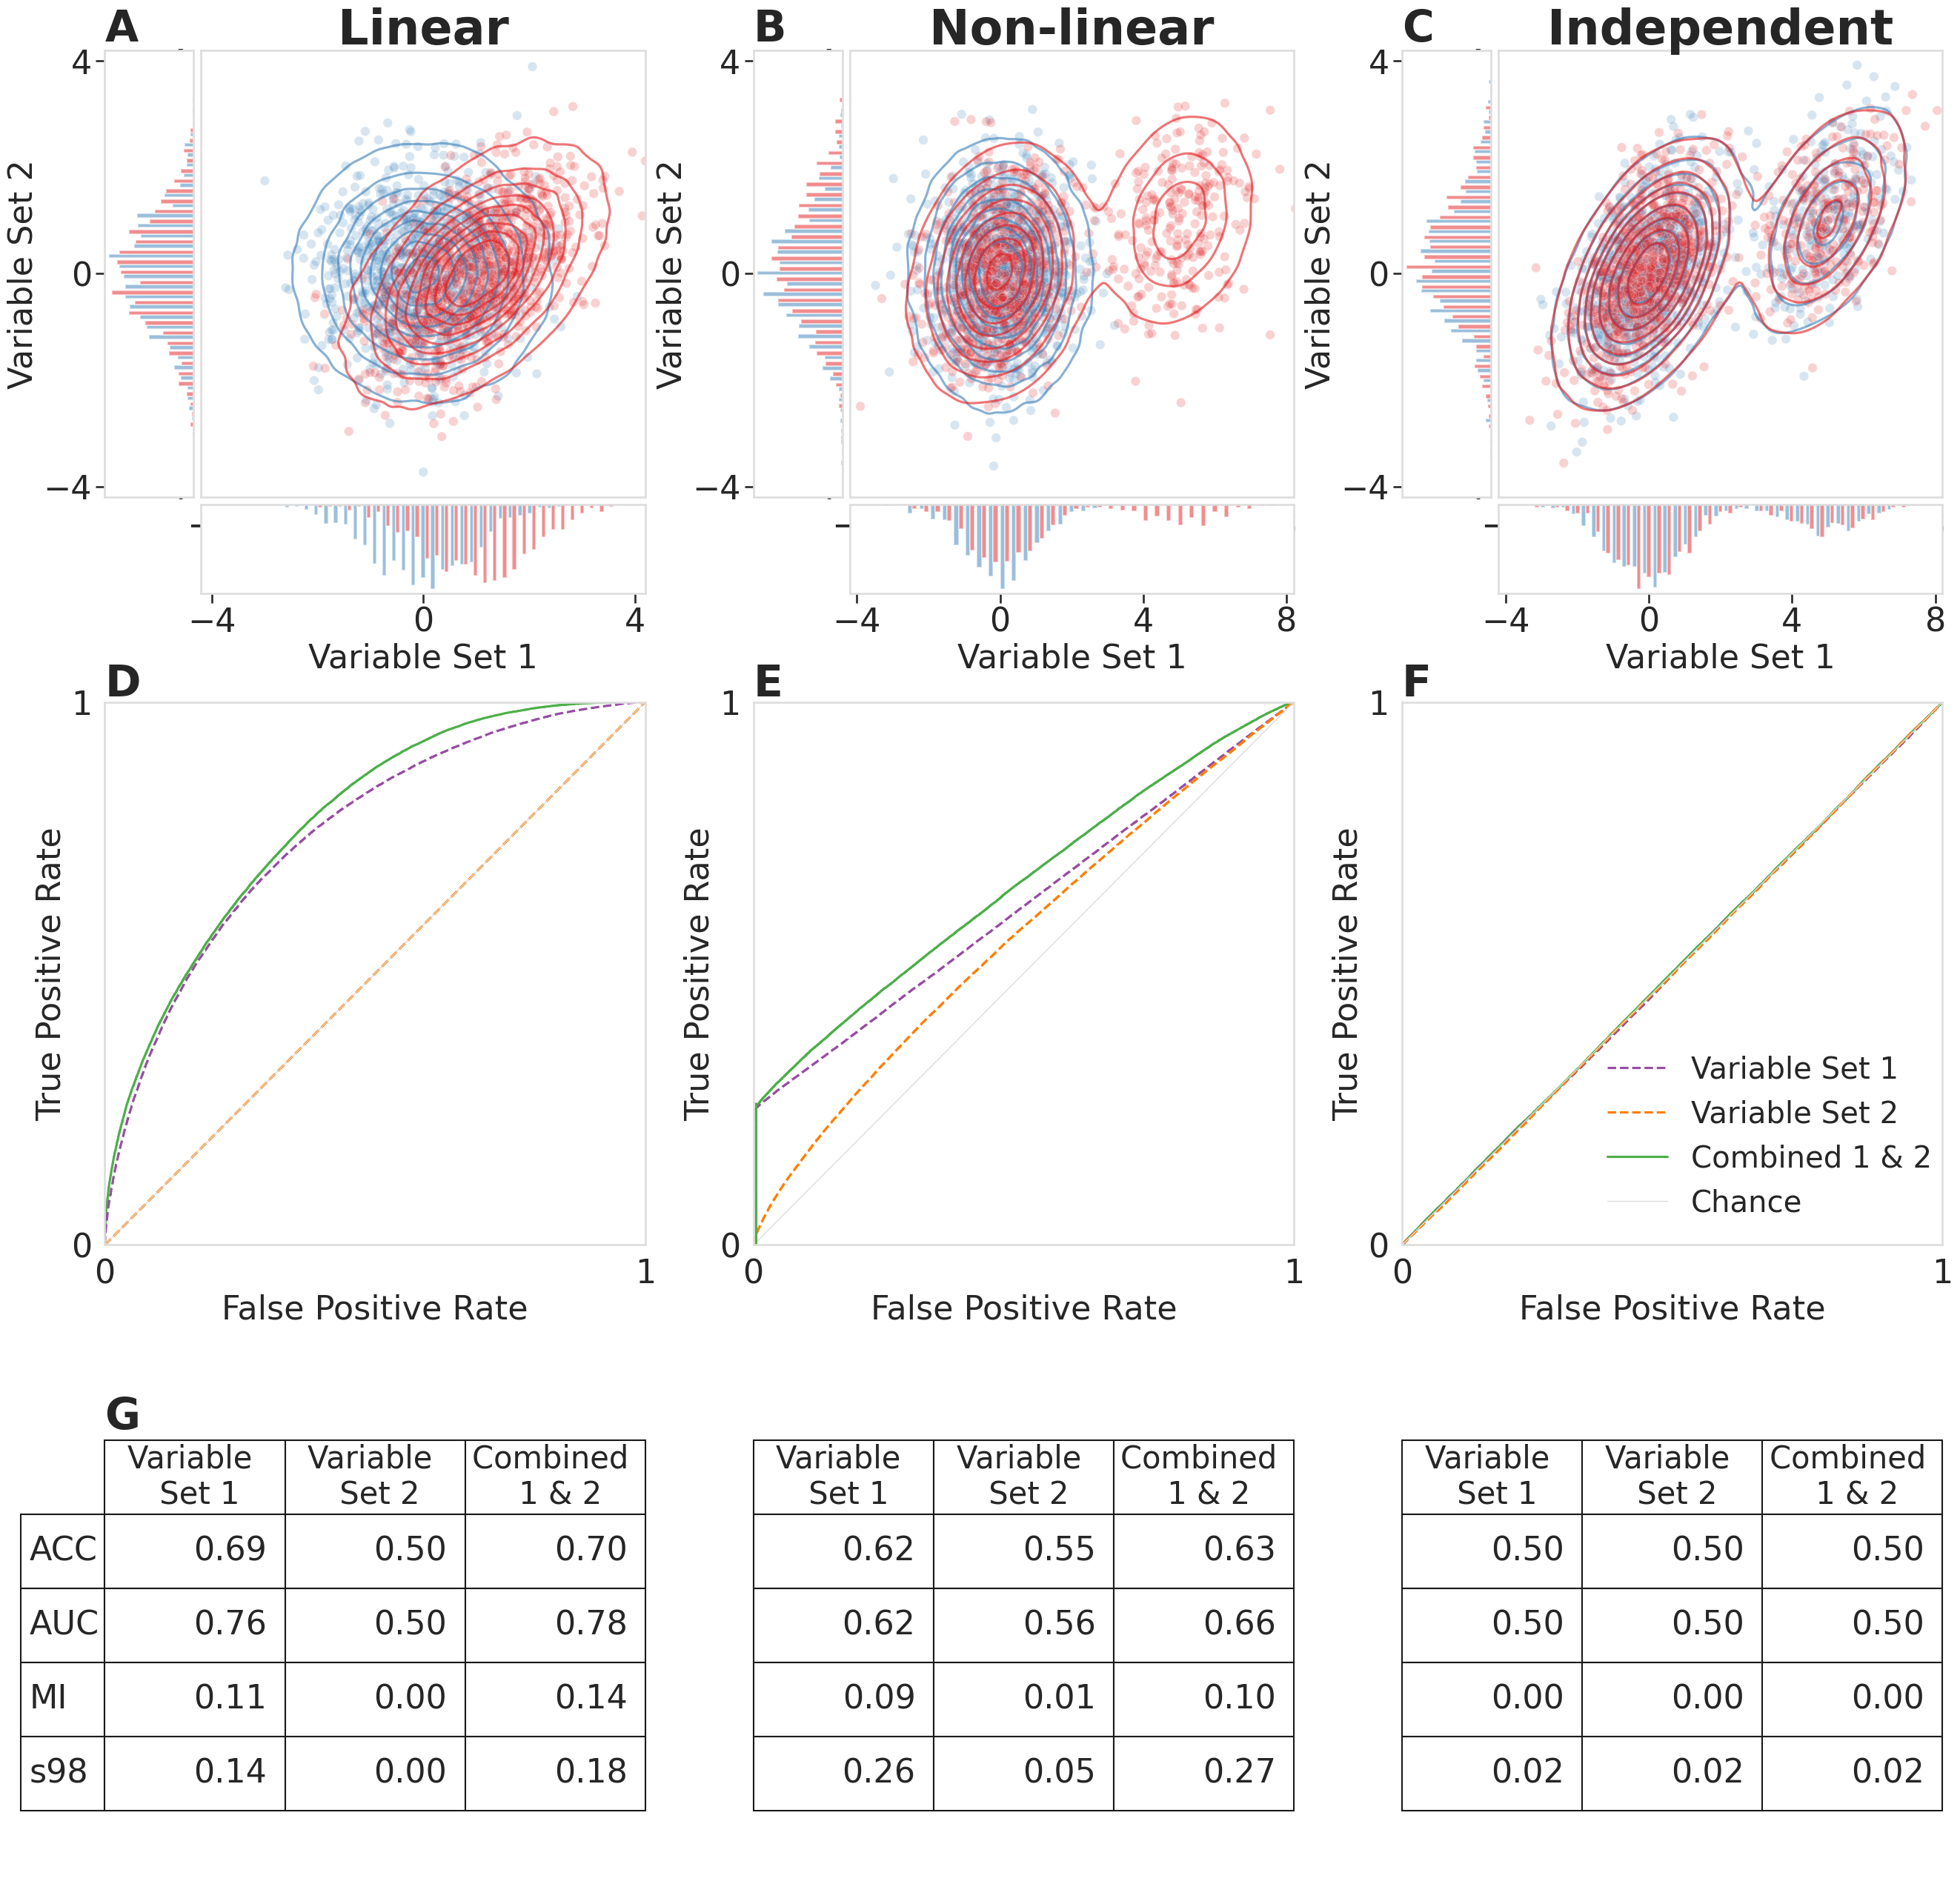

In [10]:
#supress the warnings
from unittest import skip
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.pyplot import title
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
# import string
warnings.filterwarnings('ignore')

sns.set(color_codes=True, style="white", context="talk", font_scale=2)
PALETTE = sns.color_palette("Set1")
# swap the first and second colors
PALETTE[0], PALETTE[1] = PALETTE[1], PALETTE[0]
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
SIMULATIONS = ['Linear', 'Non-linear', 'Independent']
NCOLS = 3
NROWS = 3
density = False
fontsize = axislabelfontsize =titlefontsize= 32
fig = plt.figure(figsize=(32, 28))
gs = gridspec.GridSpec(NROWS, NCOLS, fig)
sns.set_style("white", {"axes.edgecolor": "#dddddd"})


ROW = 0
fig_labels = ['A', 'B', 'C']
spacings = [18, 14, 12]
skip = n//1000
levels = 12
# bins = 35
for i in range(NCOLS):
    df = all_data[i][0]
    df_ = df[::skip]
    x_min, x_max = df["view1"].min(), df["view1"].max()
    y_min, y_max = df["view2"].min(), df["view2"].max()
    x, y = df["view1"], df["view2"]
    x_, y_ = df_["view1"], df_["view2"]
    g1 = fig.add_subplot(gs[ROW, i])
    g1 = sns.scatterplot(data=df_, x='view1', y='view2', hue=df_["label"], palette=PALETTE[:2], alpha = 0.2)
    sns.kdeplot(data=df, x='view1', y='view2', hue=df["label"], palette=PALETTE[:2], alpha = 0.6)
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)
    g1.set(ylabel=None)
    g1.tick_params(left=False)
    g1.set_title(SIMULATIONS[i], fontsize=titlefontsize+15,fontweight='bold')


    divider = make_axes_locatable(g1)
    g1Histx = divider.append_axes("bottom", 1.2, pad=0.1, sharex=g1)
    g1Histy = divider.append_axes("left", 1.2, pad=0.1, sharey=g1)
    g1Histx.tick_params(labelbottom=True, bottom=True,
                    left=False, labelleft=False, right=False, labelright=False)
    g1Histy.tick_params(labelleft=True, left=True,
                        bottom=False, labelbottom=False, top=False, labeltop=False)
    g1Histx.invert_yaxis()
    g1Histy.invert_xaxis()
    g1Histx.hist((x_[df_["label"] == 'Control'],x_[ df_["label"] == 'Case']), bins=40, density=True,color = PALETTE[:2],alpha = 0.5)
    # sns.kdeplot(data=df, x='view1', hue=df["label"], palette=PALETTE[:2], alpha = 0.6,ax=g1Histx)
    g1Histy.hist((y_[df_["label"] == 'Control'],y_[ df_["label"] == 'Case']), bins=40, density=True, orientation='horizontal',color = PALETTE[:2],alpha = 0.5)
    # sns.kdeplot(data=df, x='view2', hue=df["label"], palette=PALETTE[:2], alpha = 0.6,ax=g1Histy)
    g1Histx.set_xlabel('Variable Set 1',fontsize =axislabelfontsize)
    g1Histx.tick_params(axis='both', which='major', labelsize=axislabelfontsize)

    g1Histy.set_title(fig_labels[i], loc="left", weight='bold', fontsize=fontsize+10)
    g1Histy.set_ylabel('Variable Set 2',fontsize =axislabelfontsize)
    g1Histy.tick_params(axis='both', which='major', labelsize=axislabelfontsize)

    g1Histy.set_ylim([-4.2, 4.2])
    g1Histy.set_yticks([-4, 0, 4],)
    if i == 0:
      g1Histx.set_xlim([-4.2, 4.2])
      g1Histx.set_xticks([-4, 0,4])


    #   # g1.set_yticks([-4, 0, 4])
    else:
      g1Histx.set_xlim([-4.2, 8.2])
      g1Histx.set_xticks([-4, 0,4,8])

    g1.figure.subplots_adjust(top=1) # Reduce plot to make room
    g1.get_legend().remove()

ROW += 1
# ax = plt.subplots(nrows=1, ncols=3, figsize=(26,8), gridspec_kw={'width_ratios': [.8, .8, .8]})
fig_labels = ['D', 'E', 'F']
for i in range(NCOLS):
    df_roc, df_roc_v1, df_roc_v2 = all_data[i][3:6]
    ax = fig.add_subplot(gs[ROW, i]) # aspect=1.0
    # ax.set_aspect('equal')
    # ax.set_aspect(0.95)
    # sns.lineplot(data=df_roc_all, x="fpr", y="tpr", hue="view", ax=ax)
    # ax.set_title(SIMULATIONS[i], fontsize=titlefontsize)

    ax.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[2], label="Combined 1 & 2", linestyle="-")
    ax.plot(df_roc_v1["fpr"], df_roc_v1["tpr"], color=PALETTE[3], label="Variable Set 1", linestyle="--")
    ax.plot(
        df_roc_v2["fpr"],
        df_roc_v2["tpr"],
        color=PALETTE[4],
        linestyle="--",
        label="Variable Set 2",
    )
    ax.plot([0, 1], [0, 1], color='#dddddd', lw=1, linestyle="-", label="Chance")
    handles, labels = plt.gca().get_legend_handles_labels()
    print(labels)
    order = [1,2,0,3]

    if i == 1:
        # get the s98 values
        s98 = all_data[i][6].loc['joint', 's98']
        ax.vlines(x=0.005, ymin=0,ymax=s98-0.01, color=PALETTE[2], linestyle='-')
    ax.set_xlabel("False Positive Rate", fontsize=axislabelfontsize)
    ax.set_ylabel("True Positive Rate", fontsize=axislabelfontsize)
    ax.set_title(fig_labels[i], loc="left", weight='bold', fontsize=fontsize+10)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_ylim(top=1)
    ax.set_xlim(right=1)
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.tick_params(axis='both', which='major', labelsize=axislabelfontsize)
    ax.set_axisbelow(True)
    ax.spines['left'].set_color('#dddddd')
    ax.spines['right'].set_color('#dddddd')
    ax.spines['top'].set_color('#dddddd')
    ax.spines['bottom'].set_color('#dddddd')

    if i ==2:
      ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=fontsize-3, frameon=False,
                loc="lower left",ncol = 1,bbox_to_anchor=(0.33, -0))
      # ax.legend(['Combined 1 & 2','Variable Set 1','Variable Set 2','Chance'],fontsize=fontsize, frameon=False)
      # handles, labels = ax.get_legend_handles_labels()
      # sort both labels and handles by labels
      # labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
      # ax.legend(handles, labels, fontsize=fontsize-2, frameon=False,loc="lower left",ncol = 4,bbox_to_anchor=(-0.2,-0.25))

    # plt.subplots_adjust(wspace=1)

    # annotate the stats on the plot
    stats = all_data[i][6]
    # print(stats)
    MI = stats.loc['joint', "MI"]
    CMI = stats.loc['view1', "CMI"]
    s98 = stats.loc['joint', "s98"]
    AUC = stats.loc['joint', "AUC"]
    Acc = stats.loc['joint', "ACC"]
    # x_pos = 0.5
    # y_pos = 0.1
    # k = 0.08
    # for j, txt in enumerate([f"CMI : {CMI:.2f}", f"S@98: {s98:.2f}", f"Acc : {Acc:.2f}",f"AUC : {AUC:.2f}"]):
    #     ax.text(
    #         x_pos,
    #         y_pos + k * j,
    #         txt,
    #         transform=ax.transAxes,
    #         fontsize=fontsize + 2,
    #         verticalalignment="top",
    #         horizontalalignment="left",
    #         family="monospace",
    #     )
# plt.suptitle(str(' '*18 + "Linear" + ' '*48 + "Non-linear" +' '*44 + "Independent"), fontsize=fontsize+15, y=1.05, fontweight='bold', horizontalalignment='center')
# save as .svg
d = d.applymap(lambda x: 'NaN' if pd.isnull(x) else format(x, ".2f"))
# d = np.round(d[~np.isnan(d)], decimals=2)
d = d.replace(np.nan, "")
for j in range(NCOLS):
  # print(j)
  ax_table = plt.subplot(gs[2,j])
  if j == 0:
    the_table = ax_table.table(cellText=d.iloc[:,[4,5,3]].values,colLabels = ['Variable \n Set 1','Variable \n Set 2','Combined \n 1 & 2'], rowLabels = d.iloc[:,3*j:3*j+3].index,loc='center')
    ax_table.set_title('G', loc="left", weight='bold', fontsize=fontsize+10,y = 0.85)

  elif j ==1:
    the_table = ax_table.table(cellText=d.iloc[:,[7,8,6]].values,colLabels = ['Variable \n Set 1','Variable \n Set 2','Combined \n 1 & 2'],loc='center')

  else:
    the_table = ax_table.table(cellText=d.iloc[:,[1,2,0]].values,colLabels = ['Variable \n Set 1','Variable \n Set 2','Combined \n 1 & 2'],loc='center')

  the_table.auto_set_font_size(False)
  # the_table.set_fontsize(fontsize)
  the_table.scale(1,6)
  ax_table.axis("off")

  cells = the_table._cells
  for cell in the_table._cells:
    if cell[0] == 0:
      the_table._cells[cell].set_fontsize(fontsize-2)
    else:
      the_table._cells[cell].set_fontsize(fontsize)




# plt.savefig("figure-s4-v2.svg", format='svg', bbox_inches='tight')
plt.show()